<a href="https://colab.research.google.com/github/Ajjme/Feedback_Systems/blob/main/VPP_Basic_Usage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

These are my three basic Python Objects

In [68]:
"""Energy resource implementations for the Virtual Power Plant."""

from abc import ABC, abstractmethod
from datetime import datetime
from typing import Dict, Any, Optional, Callable, List


class EnergyResource(ABC):
    """Abstract base class for all energy resources."""

    def __init__(
        self,
        rated_power: float,
        name: Optional[str] = None,
        metadata: Optional[Dict[str, Any]] = None,
        power_curve: Optional[Callable[[float], float]] = None
    ):
        """Initialize resource with rated power capacity and optional parameters."""
        if rated_power <= 0:
            print("Rated power must be positive")

        self.name = name or f"{self.__class__.__name__}_{id(self)}"
        self.rated_power = rated_power
        self._current_power = 0.0
        self._efficiency = 0.95  # Default efficiency
        self._online = True
        self._last_update = datetime.utcnow()
        self._metadata = metadata or {}
        self._power_curve = power_curve
        self._state_history: List[Dict[str, Any]] = []

    @abstractmethod
    def get_metrics(self) -> Dict[str, Any]:
        """Get current resource metrics."""
        return {
            "name": self.name,
            "rated_power": self.rated_power,
            "current_power": self._current_power,
            "efficiency": self._efficiency,
            "online": self._online,
            "last_update": self._last_update.isoformat(),
            **self._metadata
        }

    @property
    def is_online(self) -> bool:
        """Check if resource is online."""
        return self._online

    def set_power(self, power: float) -> None:
        """Set current power output."""
        if not self._online:
            print("Cannot set power: resource is offline")

        if power < 0 or power > self.rated_power:
            print(
                f"Power must be between 0 and {self.rated_power} kW"
            )

        # Apply custom power curve if available
        if self._power_curve:
            power = self._power_curve(power)

        self._current_power = power
        self._last_update = datetime.utcnow()

        # Record state for analysis
        self._record_state()

    def _record_state(self) -> None:
        """Record current state for analysis."""
        state = {
            "timestamp": self._last_update,
            "power": self._current_power,
            "efficiency": self._efficiency,
            **self._metadata
        }
        self._state_history.append(state)

    def get_state_history(self) -> List[Dict[str, Any]]:
        """Get resource state history for analysis."""
        return self._state_history

    def add_metadata(self, key: str, value: Any) -> None:
        """Add metadata for research/analysis."""
        self._metadata[key] = value

    def get_metadata(self) -> Dict[str, Any]:
        """Get resource metadata."""
        return self._metadata

    def set_power_curve(self, curve: Callable[[float], float]) -> None:
        """Set custom power curve function."""
        self._power_curve = curve

class Battery(EnergyResource):
    """Battery energy storage system."""

    def __init__(
        self,
        capacity: float,
        current_charge: float,
        max_power: float,
        nominal_voltage: float
    ):
        """Initialize battery with capacity and charge state."""
        super().__init__(rated_power=max_power)

      #store values and Set efficiencies
        self.capacity = capacity  # kWh
        self.current_charge = current_charge  # kWh
        self.nominal_voltage = nominal_voltage  # V
        self.charge_efficiency = 0.95
        self.discharge_efficiency = 0.95

    #this will be called when needing metrics
    def get_metrics(self) -> Dict[str, Any]:
        """Get battery-specific metrics."""
        metrics = super().get_metrics()
        metrics.update({
            "capacity": self.capacity,
            "current_charge": self.current_charge,
            "state_of_charge": self.current_charge / self.capacity * 100,
            "nominal_voltage": self.nominal_voltage,
            "charge_efficiency": self.charge_efficiency,
            "discharge_efficiency": self.discharge_efficiency
        })
        return metrics
    # calculates added energy
    def charge(self, power: float, duration: float) -> None:
        """Charge battery with given power for duration."""
        if not self.is_online:
            print("Cannot charge: battery is offline")

        if power < 0 or power > self.rated_power:
            print(
                f"Charging power must be between 0 and {self.rated_power} kW"
            )

        energy = power * duration * self.charge_efficiency
        new_charge = self.current_charge + energy

        if new_charge > self.capacity:
            print("Cannot charge: would exceed capacity")

        self.current_charge = new_charge
        self._current_power = power
        self._last_update = datetime.utcnow()

    def discharge(self, power: float, duration: float) -> None:
        """Discharge battery with given power for duration."""
        if not self.is_online:
            print("Cannot discharge: battery is offline")

        if power < 0 or power > self.rated_power:
            print(
                f"Discharge power must be between 0 and {self.rated_power} kW"
            )

        energy = power * duration / self.discharge_efficiency
        new_charge = self.current_charge - energy

        if new_charge < 0:
            print("Cannot discharge: insufficient charge")

        self.current_charge = new_charge
        self._current_power = -power  # Negative for discharge
        self._last_update = datetime.utcnow()

class Solar(EnergyResource):
    """Solar power generation system."""

    def __init__(
        self,
        peak_power: float,
        panel_area: float,
        efficiency: float
    ):
        """Initialize solar system with panel specifications."""
        super().__init__(rated_power=peak_power)

        if panel_area <= 0:
            print("Panel area must be positive")
        if efficiency <= 0 or efficiency > 1:
            print("Efficiency must be between 0 and 1")

        self.panel_area = panel_area  # m²
        self.panel_efficiency = efficiency
        self._irradiance = 0.0  # W/m²
        self._temperature = 25.0  # °C
        self._temp_coefficient = -0.004  # Typical value for Si cells

    def get_metrics(self) -> Dict[str, Any]:
        """Get solar-specific metrics."""
        metrics = super().get_metrics()
        metrics.update({
            "panel_area": self.panel_area,
            "panel_efficiency": self.panel_efficiency,
            "irradiance": self._irradiance,
            "temperature": self._temperature,
            "temp_coefficient": self._temp_coefficient
        })
        return metrics

    def update_conditions(
        self,
        irradiance: float,
        temperature: Optional[float] = None
    ) -> None:
        """Update environmental conditions and recalculate power."""
        if irradiance < 0:
            print("Irradiance cannot be negative")

        self._irradiance = irradiance
        if temperature is not None:
            self._temperature = temperature

        # Calculate power output
        base_power = (
            self._irradiance *
            self.panel_area *
            self.panel_efficiency / 1000  # Convert W to kW
        )

        # Apply temperature correction
        temp_factor = 1 + self._temp_coefficient * (self._temperature - 25)
        power = base_power * temp_factor

        # Limit to rated power
        self._current_power = min(power, self.rated_power)
        self._last_update = datetime.utcnow()

class WindTurbine(EnergyResource):
    """Wind power generation system."""

    def __init__(
        self,
        rated_power: float,
        rotor_diameter: float,
        hub_height: float,
        cut_in_speed: float,
        cut_out_speed: float,
        rated_speed: float
    ):
        """Initialize wind turbine with specifications."""
        super().__init__(rated_power=rated_power)

        if rotor_diameter <= 0:
            print("Rotor diameter must be positive")
        if hub_height <= 0:
            print("Hub height must be positive")
        if cut_in_speed < 0:
            print("Cut-in speed cannot be negative")
        if cut_out_speed <= cut_in_speed:
            print("Cut-out speed must be greater than cut-in speed")
        if rated_speed <= cut_in_speed or rated_speed >= cut_out_speed:
            print(
                "Rated speed must be between cut-in and cut-out speeds"
            )

        self.rotor_diameter = rotor_diameter
        self.hub_height = hub_height
        self.cut_in_speed = cut_in_speed
        self.cut_out_speed = cut_out_speed
        self.rated_speed = rated_speed

        self._wind_speed = 0.0
        self._air_density = 1.225  # kg/m³ at sea level, 15°C
        self._power_coefficient = 0.4  # Typical value

    def get_metrics(self) -> Dict[str, Any]:
        """Get wind turbine-specific metrics."""
        metrics = super().get_metrics()
        metrics.update({
            "rotor_diameter": self.rotor_diameter,
            "hub_height": self.hub_height,
            "cut_in_speed": self.cut_in_speed,
            "cut_out_speed": self.cut_out_speed,
            "rated_speed": self.rated_speed,
            "wind_speed": self._wind_speed,
            "air_density": self._air_density,
            "power_coefficient": self._power_coefficient
        })
        return metrics

    def update_wind(
        self,
        wind_speed: float,
        air_density: Optional[float] = None
    ) -> None:
    #to remove all resource error checks
        """Update wind conditions and recalculate power output."""
        if wind_speed < 0:
            print("Wind speed cannot be negative")

        self._wind_speed = wind_speed
        if air_density is not None:
            if air_density <= 0:
                print("Air density must be positive")
            self._air_density = air_density

        # Calculate power based on wind speed
        if wind_speed < self.cut_in_speed or wind_speed > self.cut_out_speed:
            power = 0.0
        elif wind_speed >= self.rated_speed:
            power = self.rated_power
        else:
            # Power curve between cut-in and rated speed
            swept_area = 3.14159 * (self.rotor_diameter / 2) ** 2
            power = (
                0.5 *
                self._air_density *
                swept_area *
                wind_speed ** 3 *
                self._power_coefficient / 1000  # Convert W to kW
            )
            power = min(power, self.rated_power)

        self._current_power = power
        self._last_update = datetime.utcnow()


In [69]:
""" ploting function """
import matplotlib.pyplot as plt

def plot_results(results: Dict):
    """Plot simulation results."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Power output plot
    ax1.plot(results['time'], results['total_power'], 'k-', label='Total')
    ax1.plot(results['time'], results['solar_power'], 'y-', label='Solar')
    ax1.plot(results['time'], results['wind_power'], 'b-', label='Wind')
    ax1.plot(results['time'], results['battery_power'], 'r-', label='Battery')
    ax1.plot(results['time'], results['demand'], 'm-', label='Demand')
    ax1.set_ylabel('Power (kW)')
    ax1.legend()
    ax1.grid(True)

    # Battery SOC and market price
    ax2.plot(results['time'], results['battery_soc'], 'g-', label='Battery SOC')

    ax2.set_ylabel('Battery SOC (%)')

    lines1, labels1 = ax2.get_legend_handles_labels()
    ax2.legend(lines1, labels1)
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

Cannot discharge: insufficient charge
Discharge power must be between 0 and 250 kW
Cannot discharge: insufficient charge
Discharge power must be between 0 and 250 kW
Cannot discharge: insufficient charge
Discharge power must be between 0 and 250 kW
Cannot discharge: insufficient charge
Discharge power must be between 0 and 250 kW
Cannot discharge: insufficient charge
Discharge power must be between 0 and 250 kW
Cannot discharge: insufficient charge
Cannot discharge: insufficient charge


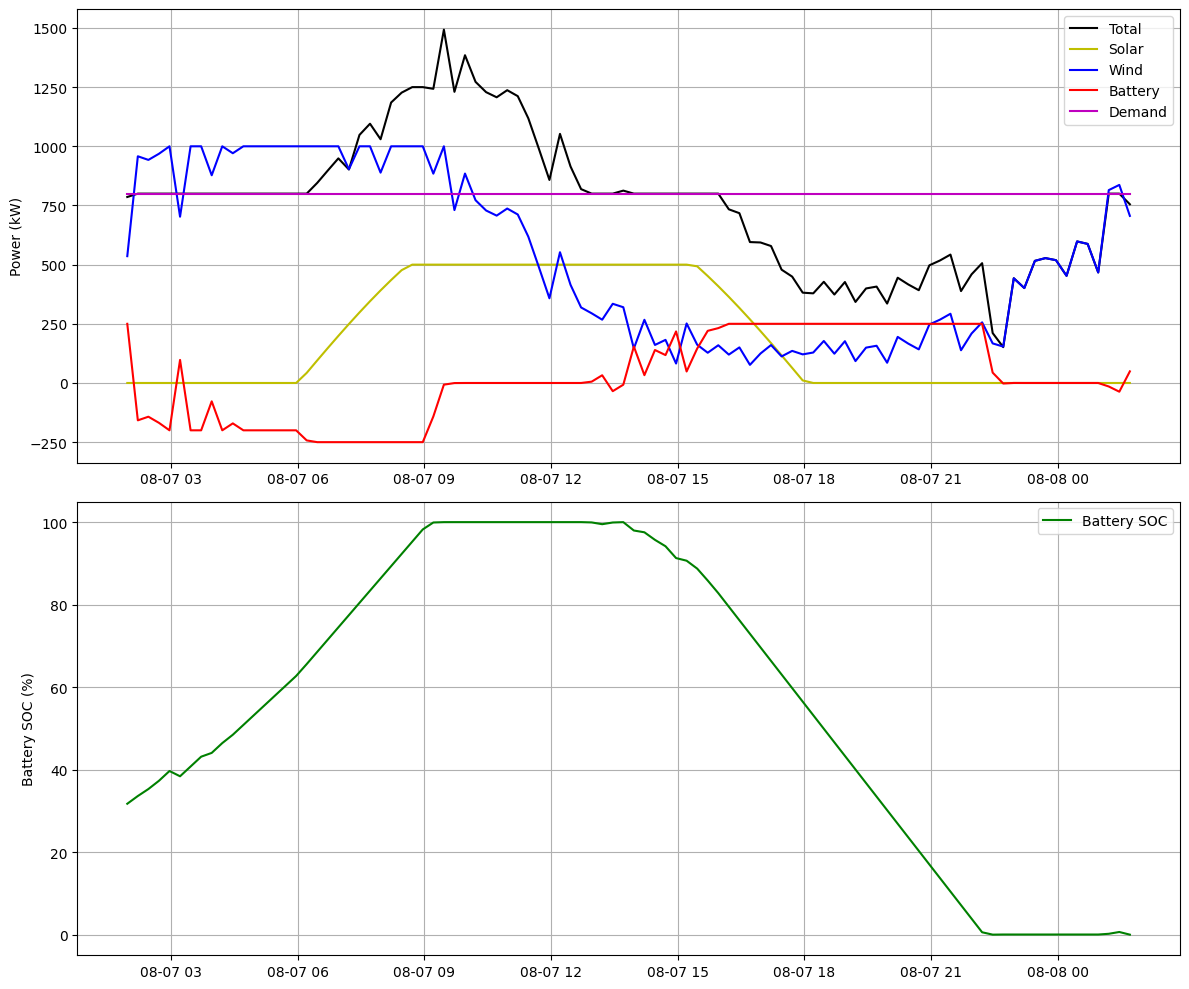

In [75]:
def run_vpp_simulation():
    # Simulation parameters
    duration_hours = 24
    dt = 15 / 60  # 15-minute intervals in hours
    steps = int(duration_hours / dt)
    base_time = datetime.now()

    # Create resources
    solar = Solar(peak_power=500, panel_area=5000, efficiency=0.20)
    wind = WindTurbine(rated_power=1000, rotor_diameter=70, hub_height=80,
                       cut_in_speed=3, cut_out_speed=25, rated_speed=12)
    battery = Battery(capacity=2000, current_charge=700, max_power=250, nominal_voltage=400)

    # Placeholder for simulation results
    results = {
        "time": [],
        "solar_power": [],
        "wind_power": [],
        "battery_power": [],
        "total_power": [],
        "battery_soc": [],
        "demand": [],
        "wind_speed": [],
        "temperature": [],
        "irradiance": []
       # "net_surplus": []
    }

    for step in range(steps):
        current_time = base_time + timedelta(hours=step * dt)
        hour = current_time.hour + current_time.minute / 60.0

        # Simulate irradiance and temperature based on time of day (simple sine wave)
        irradiance = max(0, 800 * np.sin(np.pi * (hour - 6) / 12)) # 6 added to shift from 24 hour clock to 6 oclock sun rise
        temperature = 20 + 10 * np.sin(np.pi * (hour - 6) / 12) #temp in C

        # Simulate wind speed (random with trend)
        wind_speed = max(0, 8 + 3 * np.sin(np.pi * hour / 12) + np.random.normal(0, 0.5))
        #Starts at 8 miles and hour
        # natural flux built in wind speed increases during the morning, peaks around midday (12h), and decreases in the evening (evals between 0 and 1)
        # 3 is by how much this variation ranges plus or minus
        # then add random noise of plus/minus .5

        # Update resources
        solar.update_conditions(irradiance, temperature)
        wind.update_wind(wind_speed)

        # Get current generation
        solar_power = solar._current_power
        wind_power = wind._current_power
        #can play with demand
        demand = 800  # Fixed demand in kW for simplicity

        generation = solar_power + wind_power
        power_deficit = demand - generation

        # Battery logic: discharge when deficit, charge when surplus
        if power_deficit > 0:
            discharge_power = min(battery.rated_power, power_deficit, battery.current_charge / dt)
            battery.discharge(discharge_power, dt)
        else:
            charge_power = min(battery.rated_power, -power_deficit, (battery.capacity - battery.current_charge) / dt)
            battery.charge(charge_power, dt)


        # Store results
        results["time"].append(current_time)
        results["solar_power"].append(solar_power)
        results["wind_power"].append(wind_power) #(Check)
        results["battery_power"].append(-battery._current_power) #we added a negitive here to show how batteries work with the system (note within the function we need to keep the signs the other way)
        results["total_power"].append(solar_power + wind_power - battery._current_power) #battery system is discharging into the total (we cannot meet our demand after the battery runs out at 5 )
        results["battery_soc"].append(100 * battery.current_charge / battery.capacity)
        results["demand"].append(demand)
        results["wind_speed"].append(wind_speed)
        results["temperature"].append(temperature)
        results["irradiance"].append(irradiance)

        #results["net_surplus"].append(solar_power + wind_power + battery._current_power - demand)



    return results

# Run simulation and plot
results = run_vpp_simulation()
plot_results(results)


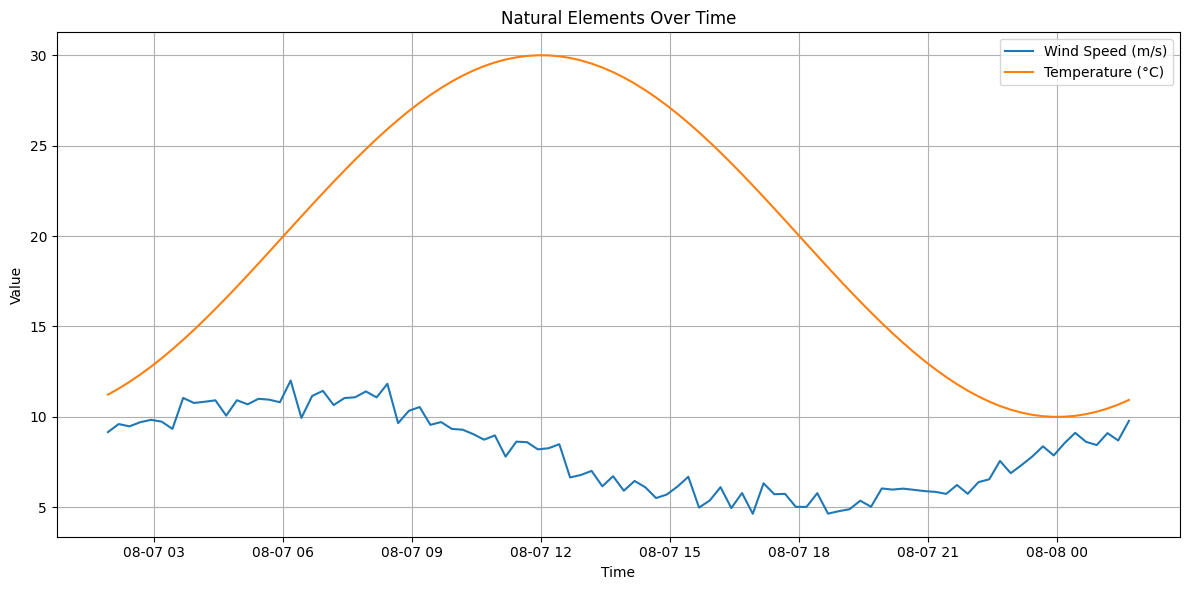

In [72]:
import matplotlib.pyplot as plt

def plot_natural_elements(results):
    time = results["time"]
    wind_speed = results["wind_speed"]
    temperature = results["temperature"]
    irradiance = results["irradiance"]

    plt.figure(figsize=(12, 6))

    #comment out what you dont want to see

    plt.plot(time, wind_speed, label="Wind Speed (m/s)")
    plt.plot(time, temperature, label="Temperature (°C)")
    #plt.plot(time, irradiance, label="Irradiance (W/m²)")

    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title("Natural Elements Over Time")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage
plot_natural_elements(results)





